In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from bams.testsystems import *
from bams.sams_adapter import SAMSAdaptor

# Comparison of SAMS methods for mixture of Gaussians
This notebook investigates the decrease in SAMS error when estimating the relative free energies of Gaussian distributions. The `Rao-Blackwellized` and `binary` update schemes will be compared. The class `GaussianMixtureSampler` will be used to sample over the mixture of Gaussian distributions, where states and configurations are generated via Gibbs sampling.

We're interested in the relative free energy between two Gaussian distributions centered at x=0 with different standard deviations. To improve the overlap between the initial and end states, intermediate Gaussian distributions will be generated by _(a)_ spacing uniformally along the thermodynamic geodesic between the start and end states and _(b)_ uniform spacing in the standard deviation. It is expected that sceanario _(a)_ will result in SAMS estimates with lower average error than _(b)_. 

### Functions to compute SAMS mean-squared error using the `GaussianMixtureSampler`

In [2]:
def rb_mse_gaussian(sigmas, niterations, nmoves=1, save_freq=1, beta=0.6, flat_hist=0.2):
    """
    Function to compute the mean-squared error from the Rao-Blackwellized update scheme in when sampling
    states with GaussianMixtureSampler.
    
    Parameters
    ----------
    sigmas: numpy array
        The standard deviations of the Gaussians that are centered on zero
    niterations: int
        The number of iterations of mixture sampling and SAMS updates that will be performed
    nmoves: int
        The number of moves from the Gaussian Gibbs sampler. One position sample and state sample 
        constitute one move.
    save_freq: int
        The frequency with which to save the state in the Gaussian mixture sampler, used to decorrelate trajectory
    beta: float
        The exponent in the burn-in phase of the two stage SAMS update scheme.
    flat_hist: float
        The average fractional difference between the target weights of the mixture and count frequency 
        
    Returns
    -------
    rb_aggregate_msd: numpy array
        the mean-squared error of the SAMS estimate for each iteration
    """
    generator = GaussianMixtureSampler(sigmas=sigmas)
    nstates = len(sigmas)
    adaptor = SAMSAdaptor(nstates=nstates, beta=beta, flat_hist=flat_hist)
    
    # The target free energy
    f_true = -np.log(sigmas) - np.log(sigmas[0])     
    
    mse = np.zeros((niterations))
    for i in range(niterations):
        generator.sample(nmoves, save_freq)
        state = generator.state
        noisy = generator.weights
        z = -adaptor.update(state=state, noisy_observation=noisy, histogram=generator.state_counter)
        generator.zetas = z
        mse[i] = np.mean((f_true[1:] - z[1:])**2)
    return mse

def binary_mse_gaussian(sigmas, niterations, nmoves=1, save_freq=1, beta=0.6, flat_hist=0.2):
    """
    Function to compute the mean-squared error from the binary update scheme in when sampling
    states with GaussianMixtureSampler.
    
    Parameters
    ----------
    sigmas: numpy array
        The standard deviations of the Gaussians that are centered on zero
    niterations: int
        The number of iterations of mixture sampling and SAMS updates that will be performed
    nmoves: int
        The number of moves from the Gaussian Gibbs sampler. One position sample and state sample 
        constitute one move.
    save_freq: int
        The frequency with which to save the state in the Gaussian mixture sampler, used to decorrelate trajectory
    beta: float
        The exponent in the burn-in phase of the two stage SAMS update scheme.
    flat_hist: float
        The average fractional difference between the target weights of the mixture and count frequency 
        
    Returns
    -------
    rb_aggregate_msd: numpy array
        the mean-squared error of the SAMS estimate for each iteration
    """
    generator = GaussianMixtureSampler(sigmas=sigmas)
    nstates = len(sigmas)
    adaptor = SAMSAdaptor(nstates=nstates, beta=beta, flat_hist=flat_hist)
        
    # The target free energy
    f_true = -np.log(sigmas) - np.log(sigmas[0])  
    
    mse = np.zeros((niterations))
    for i in range(niterations):
        noisy = generator.sample(nmoves, save_freq)
        state = generator.state
        z = -adaptor.update(state=state, noisy_observation=noisy, histogram=generator.state_counter)
        generator.zetas = z
        mse[i] = np.mean((f_true[1:] - z[1:])**2)
    return mse

## Optimally spacing $\sigma$ using thermodynamic length
The thermodynamic length between two one-dimentional Gaussian distributions centered at 0 with standard deviations $\sigma_i$ and $\sigma_f$ is given by

$$ L = \sqrt{2}\ln\left(\frac{\sigma_f}{\sigma_i}\right) $$

The goal is to space $N$ intermediate $\sigma$s between $\sigma_i$ and $\sigma_f$ such that the respective distributions equally spaced in terms of thermodynamic length. This is satisfied by choosing

$$ \sigma_n = \sigma_i \exp\left(\frac{nL}{\sqrt{2}(N-1)}\right), \, \, \, n = 0, 1, ..., N-1 $$

where $\sigma_n$ is the $n$th intermediate standard deviation. Defining functions below to implement these equations:

In [3]:
def thermo_length(s_min, s_max):
    """
    Function to compute the thermodynamic length between one-dimentional Gaussian distributions that differ
    only by their standard deviation.
    """
    return np.sqrt(2.0) * np.log(s_max / s_min)

def gen_optimal_sigmas(s_min, s_max, N):
    """
    Generate N standard deviations between s_min and s_max (inclusive) such that the resultant Gaussian distributions
    are equally spaced with respect to thermodynamic length.
    """
    sigmas = np.repeat(s_min, N)
    n = np.arange(0, N)
    return sigmas * np.exp((n * thermo_length(s_min, s_max)) / (np.sqrt(2) * (N - 1)))

To confirm that `gen_sigmas` really does space the standard deviations equidistantly with respect to thermodynamic length, see the below:

In [4]:
s_i = 1             # The initial standard deviation
s_f = 100           # The final standard deviation
N = 10              # The total number states, including intermediates

# Generating the standard deviations that have been spaced with respect to standard deviation:
sigmas_example = gen_optimal_sigmas(s_i, s_f, N)
lengths = []
for i in range(N - 1):
    lengths.append(thermo_length(sigmas_example[i], sigmas_example[i+1]))
lengths = np.array(lengths)

print('The thermodynamic lengths between each adjacent distribution are:\n')
print(np.round(lengths,2))

The thermodynamic lengths between each adjacent distribution are:

[ 0.72  0.72  0.72  0.72  0.72  0.72  0.72  0.72  0.72]


## Comparing Rao-Blackwellized and Binary update schemes for optimal spacing of states
Setting the parameters for the distributions and SAMS parameters that will be shared between the schemes.

In [5]:
# The initial and final standard deviations along with the optimally spaced intermediates
nstates = 10
s_min = 1
s_max = 500
sigmas_optimal = gen_optimal_sigmas(s_min, s_max, nstates)

# SAMS parameters
niterations = 2000
repeats = 50

# Parameters for the Gaussian mixture sampler
nmoves = 1
save_freq = 1

# The number of estimations and sampling repeats to quantify the average error:
repeats = 50

Running SAMS using the `binary` and `Rao-Blackwellized` update schemes

In [6]:
rb_aggregate_mse = np.zeros((repeats,niterations))
binary_aggregate_mse = np.zeros((repeats,niterations))
for r in range(repeats):
    rb_aggregate_mse[r,:] = rb_mse_gaussian(sigmas_optimal, niterations)
    binary_aggregate_mse[r,:] = binary_mse_gaussian(sigmas_optimal, niterations)
    
# Computing the mean error and standard error of that mean
binary_mean = binary_aggregate_mse.mean(axis=0)
rb_mean = rb_aggregate_mse.mean(axis=0)

#### Plotting the convergence

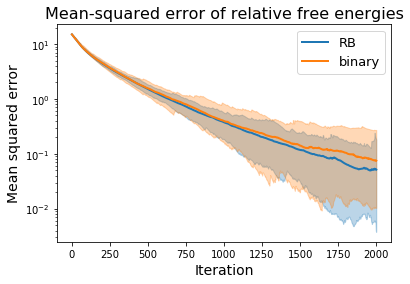

In [7]:
# Plotting parameters
alpha = 0.3           # The transparency of the spread
t = np.arange(1, niterations + 1)

# Rao-Blackwellized
upper = np.percentile(rb_aggregate_mse, 97.5, axis=0)
lower = np.percentile(rb_aggregate_mse, 2.5, axis=0)
plt.semilogy(t, rb_mean, lw=2, label='RB', color='C0')
plt.fill_between(t, lower, upper, alpha=alpha, color='C0')

# Binary
upper = np.percentile(binary_aggregate_mse, 97.5, axis=0)
lower = np.percentile(binary_aggregate_mse, 2.5, axis=0)
plt.semilogy(t, binary_mean, lw=2, label='binary', color='C1')
plt.fill_between(t, lower, upper, alpha=alpha, color='C1')

#plt.ylim(1E-1,1E1)
plt.title('Mean-squared error of relative free energies', fontsize=16)
plt.ylabel('Mean squared error', fontsize=14)
plt.xlabel('Iteration', fontsize=14)
plt.legend(fontsize=13)
plt.show()

In order to show the intrinsic uncertainty of each method, the shaded region contains 95% of all repeats. Interestingly, both the `binary` and `Rao-Blackwellized` have a similar average rates of convergence. 

## Comparing the spacing of $\sigma$
It is expected that spacing $\sigma$ such that the distributions are equidistant in terms of thermodynamic length will result in better converged SAMS results compared to when the intermediate $\sigma$s are spaced otherwise. This section compares the `Rao-Blackwellized` update with optimally spaced $\sigma$s to uniformaly (non-optimally) spaced $\sigma$s. 

In [8]:
sigmas_uniform = np.linspace(s_min, s_max, nstates)

Viewing the differences between the intermediate standard deviations:

In [9]:
print('Optimally spaced intermediate standard deviations:\n')
print(sigmas_optimal)
print('\nUniformally spaced intermediate standard deviations:\n')
print(sigmas_uniform)

Optimally spaced intermediate standard deviations:

[   1.            1.9947366     3.9789741     7.93700526   15.83223488
   31.58113835   62.99605249  125.66053149  250.65966118  500.        ]

Uniformally spaced intermediate standard deviations:

[   1.           56.44444444  111.88888889  167.33333333  222.77777778
  278.22222222  333.66666667  389.11111111  444.55555556  500.        ]


In [10]:
rb_uniform_aggregate_mse = np.zeros((repeats,niterations))
for r in range(repeats):
    rb_uniform_aggregate_mse[r,:] = rb_mse_gaussian(sigmas_uniform, niterations)
    
# Computing the mean error over all repeats
rb_uniform_mean = rb_uniform_aggregate_mse.mean(axis=0)

#### Plotting

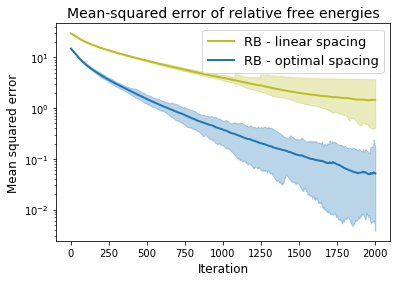

In [11]:
# Plotting parameters
alpha = 0.3              # The transparency of the spread
t = np.arange(1, niterations + 1)

# Rao-Blackwellized with uniformly spaced distributions
upper = np.percentile(rb_uniform_aggregate_mse, 97.5, axis=0)
lower = np.percentile(rb_uniform_aggregate_mse, 2.5, axis=0)
plt.semilogy(t, rb_uniform_mean, lw=2, label='RB - linear spacing', color='C8')
plt.fill_between(t, lower, upper, alpha=alpha, color='C8')

# Rao-Blackwellized with optimally generated standard deviations
upper = np.percentile(rb_aggregate_mse, 97.5, axis=0)
lower = np.percentile(rb_aggregate_mse, 2.5, axis=0)
plt.semilogy(t, rb_mean, lw=2, label='RB - optimal spacing', color='C0')
plt.fill_between(t, lower, upper, alpha=alpha, color='C0')

plt.title('Mean-squared error of relative free energies', fontsize=14)
plt.ylabel('Mean squared error', fontsize=12)
plt.xlabel('Iteration', fontsize=12)
plt.legend(fontsize=13)
plt.show()

Uniformly spacing the standard deviations results in, on average, roughly an order of magnitude increase in the mean-squared error.